In [1]:
from tensorflow.keras import backend as K
K.clear_session()

In [2]:
!pip install rarfile

In [3]:
import gdown
import rarfile
import os

# Correct URL after permissions are updated
url = 'https://drive.google.com/uc?id=1ObO-pLyN4vVmL7tGW3RrkciDlnnGU2qX'
output_rar = '/content/Wheat.rar'

# Download the RAR file
gdown.download(url, output_rar, quiet=False)

# Check if the downloaded file is valid before extracting
if os.path.exists(output_rar):
    try:
        # Try to open the downloaded file as a RAR file
        with rarfile.RarFile(output_rar, 'r') as rar_ref:
            rar_ref.extractall('/content')
        print("File extracted successfully!")
    except rarfile.NotRarFile:
        print("Error: The downloaded file is not a valid RAR archive.")
else:
    print("Error: File not found.")

Downloading...
From (original): https://drive.google.com/uc?id=1ObO-pLyN4vVmL7tGW3RrkciDlnnGU2qX
From (redirected): https://drive.google.com/uc?id=1ObO-pLyN4vVmL7tGW3RrkciDlnnGU2qX&confirm=t&uuid=4763dcbf-f098-41ca-aea7-97e22aeb8a7f
To: /content/Wheat.rar
100%|██████████| 234M/234M [00:02<00:00, 84.7MB/s]


File extracted successfully!


In [7]:
# Path to the extracted dataset folder

dataset = '/content/Wheat'

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, Input, concatenate
from tensorflow.keras.models import Model

# Function for MobileNet's Depthwise Separable Convolution
def depthwise_separable_conv(x, pointwise_filters, strides=(1, 1)):
    # Depthwise Convolution (MobileNet)
    x = DepthwiseConv2D((3, 3), padding='same', strides=strides, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)  # Using ReLU(6) as in MobileNet

    # Pointwise Convolution (MobileNet)
    x = Conv2D(pointwise_filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)

    return x

# Function for InceptionV3's Inception Module, now with LeakyReLU
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 Convolution with LeakyReLU
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same')(x)
    conv_1x1 = BatchNormalization()(conv_1x1)
    conv_1x1 = LeakyReLU(alpha=0.1)(conv_1x1)

    # 3x3 Convolution Path with LeakyReLU
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same')(x)
    conv_3x3 = BatchNormalization()(conv_3x3)
    conv_3x3 = LeakyReLU(alpha=0.1)(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same')(conv_3x3)
    conv_3x3 = BatchNormalization()(conv_3x3)
    conv_3x3 = LeakyReLU(alpha=0.1)(conv_3x3)

    # 5x5 Convolution Path with LeakyReLU
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same')(x)
    conv_5x5 = BatchNormalization()(conv_5x5)
    conv_5x5 = LeakyReLU(alpha=0.1)(conv_5x5)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same')(conv_5x5)
    conv_5x5 = BatchNormalization()(conv_5x5)
    conv_5x5 = LeakyReLU(alpha=0.1)(conv_5x5)

    # Pooling Path with LeakyReLU
    pool_proj = tf.keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same')(pool_proj)
    pool_proj = BatchNormalization()(pool_proj)
    pool_proj = LeakyReLU(alpha=0.1)(pool_proj)

    # Concatenate all paths
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
    return output

# Building the Hybrid Model
def build_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    input_layer = Input(shape=input_shape)

    # Initial Conv Layer from MobileNet
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)  # ReLU(6) as in MobileNet

    # Depthwise Separable Blocks from MobileNet
    x = depthwise_separable_conv(x, 64, strides=(1, 1))  # MobileNet Block
    x = depthwise_separable_conv(x, 128, strides=(2, 2)) # MobileNet Block
    x = depthwise_separable_conv(x, 128, strides=(1, 1)) # MobileNet Block

    # Inception Module with LeakyReLU for enhanced feature extraction
    x = inception_module(x, 64, 48, 64, 64, 96, 32)      # InceptionV3 Module
    x = inception_module(x, 64, 48, 64, 64, 96, 64)      # InceptionV3 Module

    # Depthwise Separable Convolutions from MobileNet
    x = depthwise_separable_conv(x, 256, strides=(2, 2)) # MobileNet Block
    x = depthwise_separable_conv(x, 256, strides=(1, 1)) # MobileNet Block

    # Final Inception Module with LeakyReLU
    x = inception_module(x, 128, 128, 192, 32, 96, 64)   # InceptionV3 Module

    # Global Pooling Layer (For Lightweight Classification)
    x = GlobalAveragePooling2D()(x)  # Used in both MobileNet and InceptionV3

    # Output Dense Layer for Classification
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output Layer

    # Create Model
    model = Model(input_layer, output_layer)
    return model

# Initialize the Hybrid Model
hybrid_model = build_hybrid_model(input_shape=(224, 224, 3), num_classes=5)

# Compile the model for training on leaf detection dataset
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
hybrid_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 112, 112, 32)   │            128 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_22 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_10       │ (None, 112, 112, 32)   │            288 │ re_lu_22[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d_10[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_23 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ re_lu_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 112, 112, 64)   │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_24 (ReLU)           │ (None, 112, 112, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_11       │ (None, 56, 56, 64)     │            576 │ re_lu_24[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 56, 56, 64)     │            256 │ depthwise_conv2d_11[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_25 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ re_lu_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 56, 56, 128)    │            512 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_26 (ReLU)      

 Total params: 1,028,293 (3.92 MB)

 Trainable params: 1,022,213 (3.90 MB)

 Non-trainable params: 6,080 (23.75 KB)

Found 2042 images belonging to 3 classes.
Found 293 images belonging to 3 classes.
Found 594 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 476ms/step - accuracy: 0.5257 - loss: 1.5290 - val_accuracy: 0.3413 - val_loss: 1.8421
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 175ms/step - accuracy: 0.7939 - loss: 0.6053 - val_accuracy: 0.3413 - val_loss: 1.5401
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.8593 - loss: 0.4027 - val_accuracy: 0.3413 - val_loss: 1.4451
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.8704 - loss: 0.3297 - val_accuracy: 0.3413 - val_loss: 1.2993
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.8829 - loss: 0.3262 - val_accuracy: 0.3413 - val_loss: 1.1634
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9084 - loss: 0.2516 - val_accuracy: 0.3276 - val_loss: 1.4333
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9177 - loss: 0.2322 - val_accuracy: 0.3276 - val_loss: 1.9936
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9180 - loss: 0.2113 - val_accuracy: 0.331

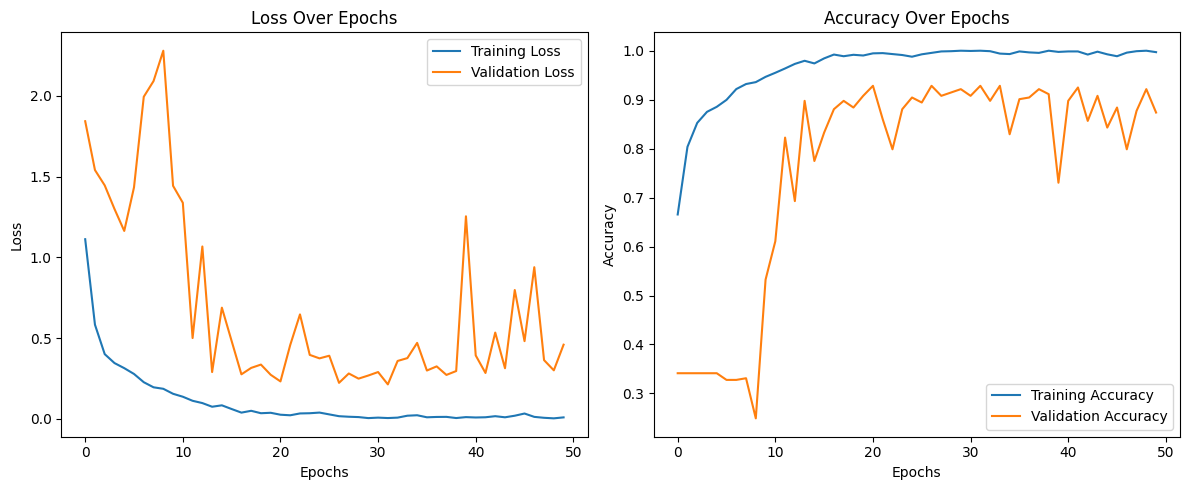

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step

Performance on Test Data
Precision: 0.9178423713091862
Recall: 0.9107744107744108
F1 Score: 0.9111883167618314
Accuracy: 0.9107744107744108
Confusion Matrix:
              Brown_Rust  Healthy  Yellow_Rust
Brown_Rust          179        4           13
Healthy               4      167           26
Yellow_Rust           3        3          195


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Directory for the dataset
data_dir = dataset  # update with the actual path to your dataset

# Use the hybrid model defined above
model = build_hybrid_model(input_shape=(224, 224, 3), num_classes=10)

# Print the model summary
# model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['Brown_Rust', 'Healthy', 'Yellow_Rust'], title="Performance on Test Data")